<a href="https://colab.research.google.com/github/Zarthan66/GoogleCollab/blob/main/AsciiArt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ascii Art with DeepLabV3 Image Segmentation**

# Getting Data

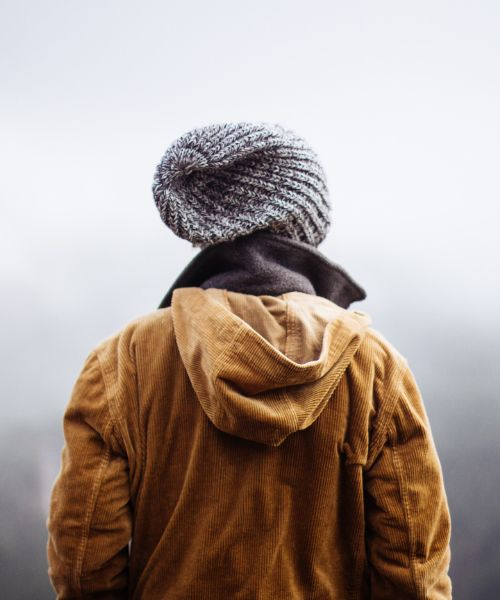

In [25]:
import cv2
from urllib.request import urlretrieve
from google.colab.patches import cv2_imshow

# save the foreground and background to our local storage
# change the link for your own pre selected image
urlretrieve('https://www.w3schools.com/html/img_girl.jpg', '/content/profile.jpg')

# display the images in the notebook
cv2_imshow(cv2.imread('/content/profile.jpg'))

# Using the Model

A few functions that we will use to remove the background

In [26]:
import cv2
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

def load_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


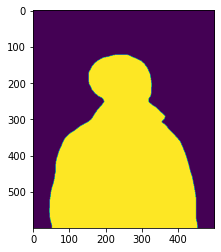

In [27]:
import numpy as np
deeplab_model = load_model()
foreground, bin_mask = remove_background(deeplab_model, '/content/profile.jpg')
plt.imshow(bin_mask)

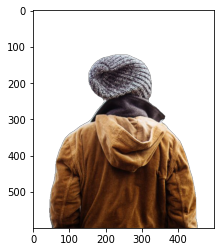

In [28]:
plt.imshow(foreground)

In [29]:
Image.fromarray(foreground).save("/content/foreground.png")

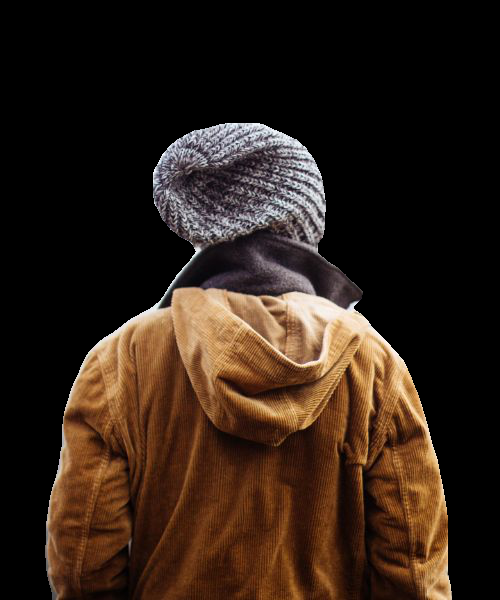

In [30]:
imgForeground = cv2.imread("/content/foreground.png")
cv2_imshow(imgForeground)

# Applying Ascii Filter

Height: 600
Width: 500
length density: 29


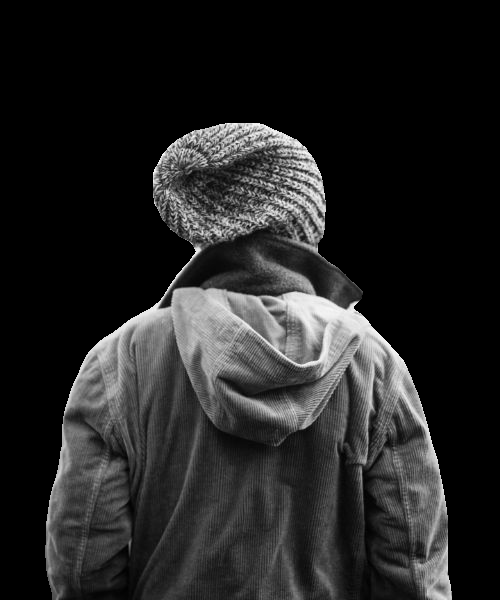

In [31]:
# Ascii filter 
density = " _.,-=+:;cba!?0123456789$#@NM"

# Get width and height
height, width = imgForeground.shape[:2]
print("Height: " + str(height))
print("Width: " + str(width))
print("length density: " + str(len(density)))

# Preview grayscale image
gray = cv2.cvtColor(imgForeground, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

# Saving the image to txt file (result.txt)

In [32]:
f = open("result.txt", "w")
text = ""

for i in range(height):
  for j in range(width):
    charIndex = int((gray[i,j] / 255) * len(density))
    if charIndex >= 0 and charIndex < len(density):
      text = text + density[charIndex]
  f.write(text + '\n')
  text = ""
f.close()

You can get the image by opening menu ***Files***📁 and download ***result.txt***

P.S Try refresh if you cant find the result.txt